# Course 3 Assignment 3

In this assignment we had to fit and assess a multiple regression model

In [1]:
# import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

## Loading and preparing data

In [2]:
# show all columns
pd.set_option('display.max_columns', None)
# loading the data from the local file
df = pd.read_csv('data/covid_data.csv')

In [3]:
# prepare data
df.date = pd.to_datetime(df.date)
dfx = df.dropna(subset=['continent'])  # gets rid of summaries for 'world' and 'africa' etc, as I only want data for countries
# the columns I need for this task
cols = ['location', 'date', 'new_cases_per_million','new_deaths_per_million', 'people_fully_vaccinated', 'human_development_index', 'population', 'extreme_poverty']
dfx = dfx[cols].dropna()  # getting rid of rows with empty data
# getting rid of rows where new cases and  deaths are below zero (due to error correction)
dfx = dfx[dfx.new_deaths_per_million >= 0]
dfx = dfx[dfx.new_cases_per_million >= 0]
# limiting it to 2021 which is when vaccinations really got started
dfx = dfx[dfx['date'].dt.year == 2021]
# so as to compare like with like, I'm keeping only countries with human development indices over 0.9
dfx = dfx[dfx.human_development_index > 0.9]
# calculating percentage of population fully vaccinated
dfx['percentage_fully_vaccinated'] = (dfx.people_fully_vaccinated/dfx.population) * 100
dfx.tail()

,location,date,new_cases_per_million,new_deaths_per_million,people_fully_vaccinated,human_development_index,population,extreme_poverty,percentage_fully_vaccinated
81005,United States,2021-04-25,96.872,0.843,94772329.0,0.926,331002647.0,1.2,28.631895
81006,United States,2021-04-26,144.080,1.432,95888088.0,0.926,331002647.0,1.2,28.968979
81007,United States,2021-04-27,153.642,1.937,96747454.0,0.926,331002647.0,1.2,29.228604
81008,United States,2021-04-28,166.539,2.897,98044421.0,0.926,331002647.0,1.2,29.620434
81009,United States,2021-04-29,175.826,2.580,99668945.0,0.926,331002647.0,1.2,30.111223


## Some plots

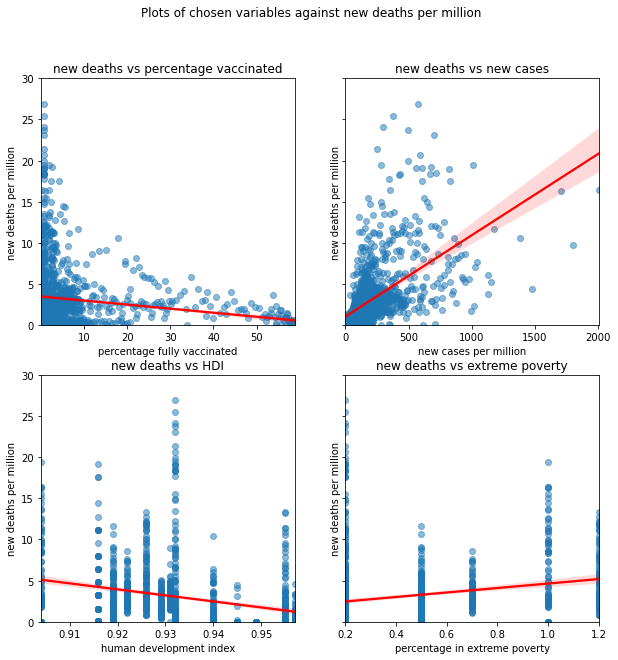

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,10))
fig.suptitle('Plots of chosen variables against new deaths per million')

sns.regplot(data=dfx, x="percentage_fully_vaccinated", y="new_deaths_per_million", scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ax=ax[0][0])
ax[0][0].set(ylim = (0, 30), xlabel='percentage fully vaccinated', ylabel='new deaths per million', title='new deaths vs percentage vaccinated')

sns.regplot(data=dfx, x="new_cases_per_million", y="new_deaths_per_million", scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ax=ax[0][1])
ax[0][1].set(ylim = (0, 30), xlabel='new cases per million', ylabel='new deaths per million', title='new deaths vs new cases')

sns.regplot(data=dfx, x="human_development_index", y="new_deaths_per_million", scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ax=ax[1][0])
ax[1][0].set(ylim = (0, 30), xlabel='human development index', ylabel='new deaths per million', title='new deaths vs HDI')

sns.regplot(data=dfx, x="extreme_poverty", y="new_deaths_per_million", scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ax=ax[1][1])
_ = ax[1][1].set(ylim = (0, 30), xlabel='percentage in extreme poverty', ylabel='new deaths per million', title='new deaths vs extreme poverty')


From these plots, as well as the previously found negative correlation between percentage fully vaccinated and new deaths per million, there is also a negative correlation between human development index and deaths per million. I thought I was controlling for HDI by selecting only countries with HDI over 0.9, but this seems not to be the case. It is also odd that as HDI increases, so do the number of new deaths and I expect there is some confounding variable that I have not discovered yet playing a part there.

There is a positive correlation, as you might expect, for new cases per million and new deaths per million, and also a positive correlation between percentage of population in extreme poverty and new deaths per million.

## Centering explanatory variables

In [5]:
dfx['c_percentage_fully_vaccinated'] = dfx.percentage_fully_vaccinated - dfx.percentage_fully_vaccinated.mean()
dfx['c_human_development_index'] = dfx.human_development_index - dfx.human_development_index.mean()
dfx['c_new_cases'] = dfx.new_cases_per_million - dfx.new_cases_per_million.mean()
dfx['c_extreme_poverty'] = dfx.extreme_poverty - dfx.extreme_poverty.mean()

In [6]:
print(dfx.c_percentage_fully_vaccinated.mean(), dfx.c_human_development_index.mean(), dfx.c_new_cases.mean(), dfx.c_extreme_poverty.mean())

0.0 2.4292059342225647e-17 -1.3603553231646363e-14 -6.073014835556412e-18


## Multiple regressions

In [7]:
# simple first
reg = smf.ols('new_deaths_per_million ~ c_percentage_fully_vaccinated', data=dfx).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     new_deaths_per_million   R-squared:                       0.024
Model:                                OLS   Adj. R-squared:                  0.023
Method:                     Least Squares   F-statistic:                     28.54
Date:                    Tue, 04 May 2021   Prob (F-statistic):           1.10e-07
Time:                            13:06:28   Log-Likelihood:                -3235.9
No. Observations:                    1170   AIC:                             6476.
Df Residuals:                        1168   BIC:                             6486.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.1337      0.113     27.853      0.000       2.913       3.354
c_percentage_fully_vaccinated    -0.0492      0.009     -5.342      0.000      -0.067      -0.031
==============================================================================
Omnibus:                      578.037   Durbin-Watson:                   0.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3308.574
Skew:                           2.280   Prob(JB):                         0.00
Kurtosis:                       9.861   Cond. No.                         12.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# trying with other values
reg = smf.ols('new_deaths_per_million ~ c_percentage_fully_vaccinated + c_new_cases', data=dfx).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     new_deaths_per_million   R-squared:                       0.330
Model:                                OLS   Adj. R-squared:                  0.329
Method:                     Least Squares   F-statistic:                     287.5
Date:                    Tue, 04 May 2021   Prob (F-statistic):          3.15e-102
Time:                            13:06:28   Log-Likelihood:                -3015.7
No. Observations:                    1170   AIC:                             6037.
Df Residuals:                        1167   BIC:                             6053.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.1337      0.093     33.606      0.000       2.951       3.317
c_percentage_fully_vaccinated    -0.0448      0.008     -5.864      0.000      -0.060      -0.030
c_new_cases                       0.0098      0.000     23.094      0.000       0.009       0.011
==============================================================================
Omnibus:                      574.939   Durbin-Watson:                   0.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4246.938
Skew:                           2.151   Prob(JB):                         0.00
Kurtosis:                      11.283   Cond. No.                         220.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

New cases per million is positively correlated (beta = 0.0098, p < 0.001) with new deaths per million, and adding it to the model increases the prediction capability of the model from 2.4% (with percentage fully vaccinated alone) to 33%.

It is not a confounding variable as percentage fully vaccinated still contributes to the model and is still significantly negatively associated with new deaths per million (beta = -0.0448, p < 0.001).

In [9]:
reg = smf.ols('new_deaths_per_million ~ c_percentage_fully_vaccinated + c_human_development_index', data=dfx).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     new_deaths_per_million   R-squared:                       0.121
Model:                                OLS   Adj. R-squared:                  0.119
Method:                     Least Squares   F-statistic:                     80.17
Date:                    Tue, 04 May 2021   Prob (F-statistic):           2.38e-33
Time:                            13:06:28   Log-Likelihood:                -3174.7
No. Observations:                    1170   AIC:                             6355.
Df Residuals:                        1167   BIC:                             6371.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.1337      0.107     29.336      0.000       2.924       3.343
c_percentage_fully_vaccinated    -0.0708      0.009     -7.917      0.000      -0.088      -0.053
c_human_development_index       -85.8516      7.569    -11.343      0.000    -100.701     -71.002
==============================================================================
Omnibus:                      610.877   Durbin-Watson:                   0.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4282.207
Skew:                           2.350   Prob(JB):                         0.00
Kurtosis:                      11.109   Cond. No.                         866.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Human development index is negatively correlated (beta = -85.8516, p < 0.001) with new deaths per million, and adding it to the model increases the prediction capability of the model from 2.4% (with percentage fully vaccinated alone) to 12.1%.

It is not a confounding variable as percentage fully vaccinated still contributes to the model and is still significantly negatively associated with new deaths per million (beta = -0.0708, p < 0.001).

In [10]:
reg = smf.ols('new_deaths_per_million ~ c_percentage_fully_vaccinated + c_extreme_poverty', data=dfx).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     new_deaths_per_million   R-squared:                       0.092
Model:                                OLS   Adj. R-squared:                  0.090
Method:                     Least Squares   F-statistic:                     58.99
Date:                    Tue, 04 May 2021   Prob (F-statistic):           3.92e-25
Time:                            13:06:29   Log-Likelihood:                -3193.7
No. Observations:                    1170   AIC:                             6393.
Df Residuals:                        1167   BIC:                             6409.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.1337      0.109     28.864      0.000       2.921       3.347
c_percentage_fully_vaccinated    -0.0637      0.009     -7.059      0.000      -0.081      -0.046
c_extreme_poverty                 3.1322      0.335      9.345      0.000       2.475       3.790
==============================================================================
Omnibus:                      670.775   Durbin-Watson:                   0.686
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5349.565
Skew:                           2.596   Prob(JB):                         0.00
Kurtosis:                      12.098   Cond. No.                         37.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The percentage of the population in extreme poverty is positively correlated (beta = 3.1322, p < 0.001) with new deaths per million, and adding it to the model increases the prediction capability of the model from 2.4% (with percentage fully vaccinated alone) to 9.2%.

It is not a confounding variable as percentage fully vaccinated still contributes to the model and is still significantly negatively associated with new deaths per million (beta = -0.0637	, p < 0.001).

In [11]:
# all together now
final = smf.ols('new_deaths_per_million ~ c_percentage_fully_vaccinated + c_human_development_index + c_new_cases + c_extreme_poverty', data=dfx).fit()
final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     new_deaths_per_million   R-squared:                       0.352
Model:                                OLS   Adj. R-squared:                  0.350
Method:                     Least Squares   F-statistic:                     158.5
Date:                    Tue, 04 May 2021   Prob (F-statistic):          2.60e-108
Time:                            13:06:29   Log-Likelihood:                -2995.9
No. Observations:                    1170   AIC:                             6002.
Df Residuals:                        1165   BIC:                             6027.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.1337      0.092     34.151      0.000       2.954       3.314
c_percentage_fully_vaccinated    -0.0563      0.008     -7.257      0.000      -0.071      -0.041
c_human_development_index       -20.6747      7.906     -2.615      0.009     -36.185      -5.164
c_new_cases                       0.0089      0.000     19.782      0.000       0.008       0.010
c_extreme_poverty                 1.2755      0.330      3.866      0.000       0.628       1.923
==============================================================================
Omnibus:                      650.122   Durbin-Watson:                   0.707
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5921.138
Skew:                           2.430   Prob(JB):                         0.00
Kurtosis:                      12.891   Cond. No.                     1.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With all explanatory variables added to the model, it is able to explain 35% of the new deaths per million values.

The beta and p-values are as follows:

percentage fully vaccinated: beta=-0.0563, p<0.001
HDI: beta=-20.6747, p=0.009
new cases per million: beta=0.0089, p<0.001
extreme poverty: beta=1.2755, p<0.001

So percentage fully vaccinated and HDI are negatively correlated with new deaths per million, while new cases and extreme poverty are positively correlated. All are significant.

A warning was given by statsmodels suggesting strong multicolinearity, which is possible given my sample is from a longitudinal study.

## Evaluating the model

C:\tools\miniconda3\envs\michigan\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


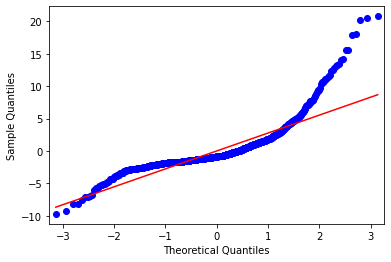

In [12]:
# qq plot
_ = sm.qqplot(final.resid, line='r')

The residuals do not follow normal distribution entirely, deviating especially at the highest quartile, suggesting more explanatory variables might be needed.

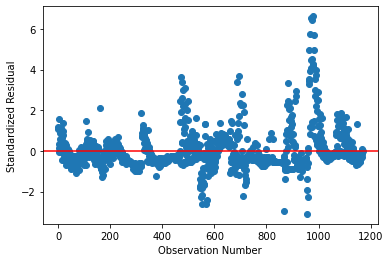

In [13]:
# simple plot of residuals
stdres = pd.DataFrame(final.resid_pearson)
plt.plot(stdres, 'o', ls='None')
l = plt.axhline(y=0, color='r')
plt.ylabel('Standardized Residual')
_ = plt.xlabel('Observation Number')

Most of my observations fall between 2 standard deviations of the mean, however some are as far as 6 standard deviations from the mean, suggesting the model is not a very good fit.

In [14]:
stdres[stdres.iloc[:, 0] > abs(2.5)].count()/len(stdres) * 100

0    3.076923
dtype: float64

In [15]:
stdres[stdres.iloc[:, 0] > abs(2)].count()/len(stdres) * 100

0    4.444444
dtype: float64

More than 3% of my observations are more than 2.5 standard deviations, and 4.4% of them are more than 2 standard deviations from the mean. Again this suggests the model is a poor fit and needs improvement.

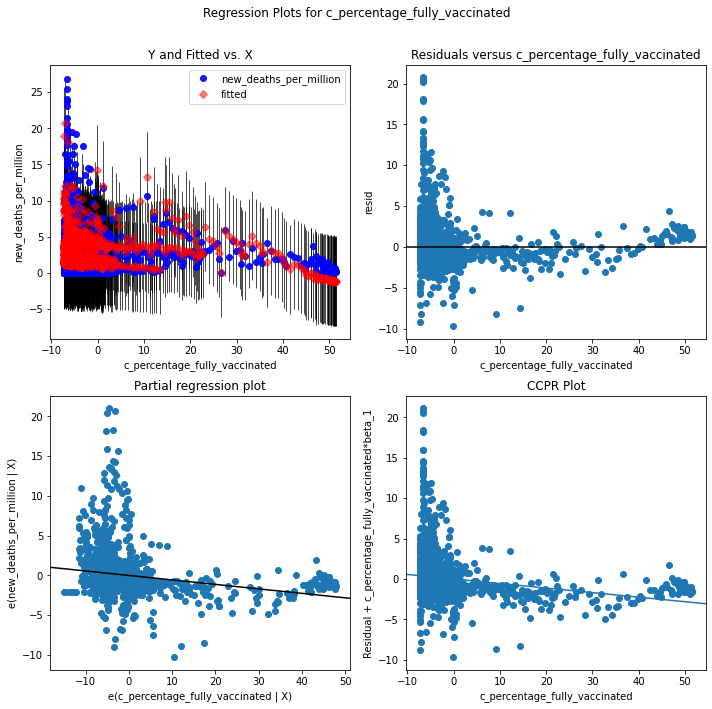

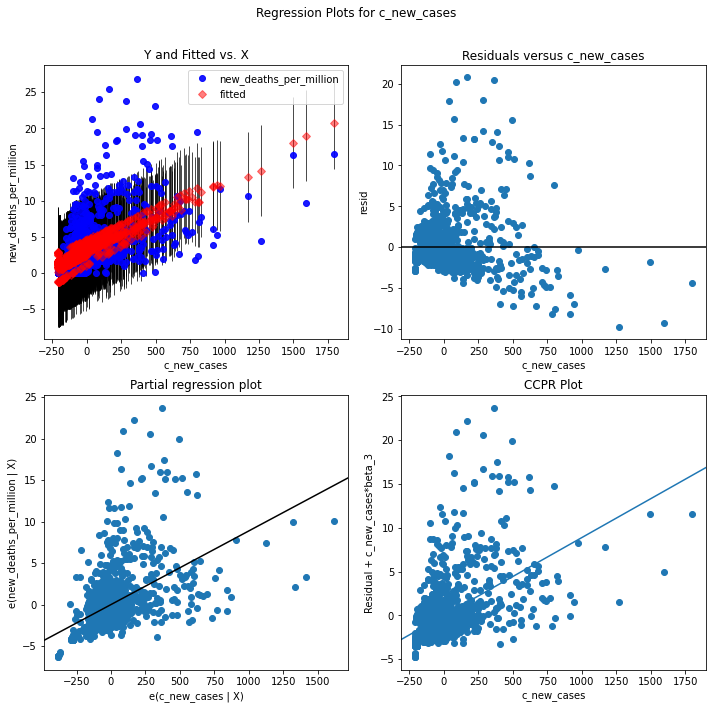

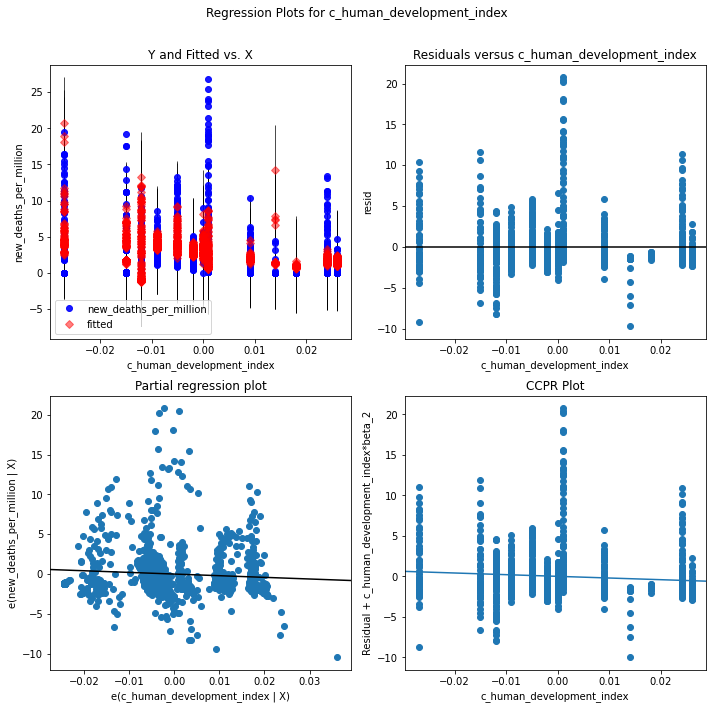

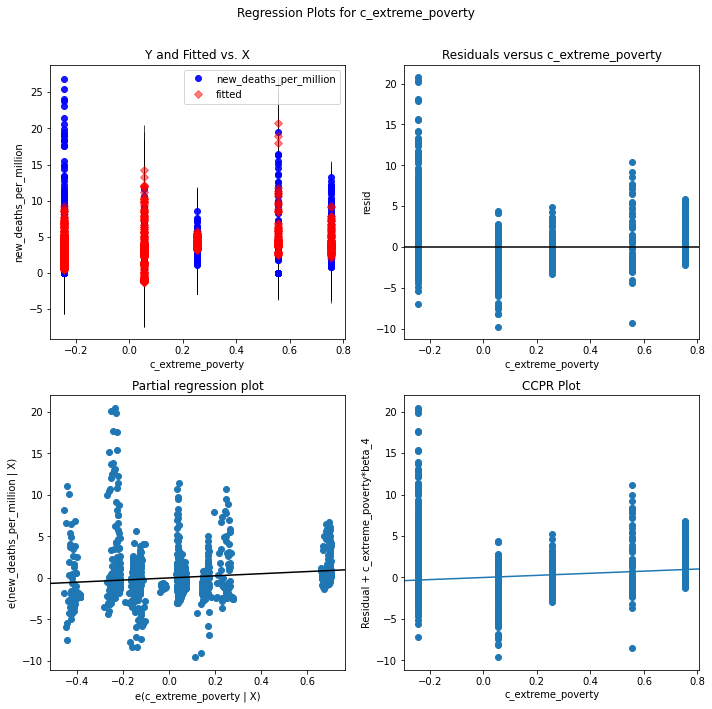

In [16]:
lst = ['c_percentage_fully_vaccinated', 'c_new_cases', 'c_human_development_index', 'c_extreme_poverty']

for l in lst:
    # additional regression diagnostic plots
    fig2 = plt.figure(figsize=(10, 10))
    fig2 = sm.graphics.plot_regress_exog(final,  l, fig=fig2)

Looking at the plots of residuals for each observation for each of my variables:
- population fully vaccinated has bigger errors at lower values. It may show signs of a slight curve, as the residuals increase again at higher levels, perhaps suggesting a polynomial regression might be useful.
- new cases has bigger errors at lower values.
- HDI has most errors at 0, but they are otherwise more evenly spread.
- extreme poverty has bigger errors at lower values.

Looking at the partial regression plots, in all cases there are many errors far from the lines suggesting a great number of prediction errors. The poplulation fully vaccinated partial regression plot may show signs of a slight curve suggesting a polynomial regression might be useful, but the others do not show such signs, and so are linear.

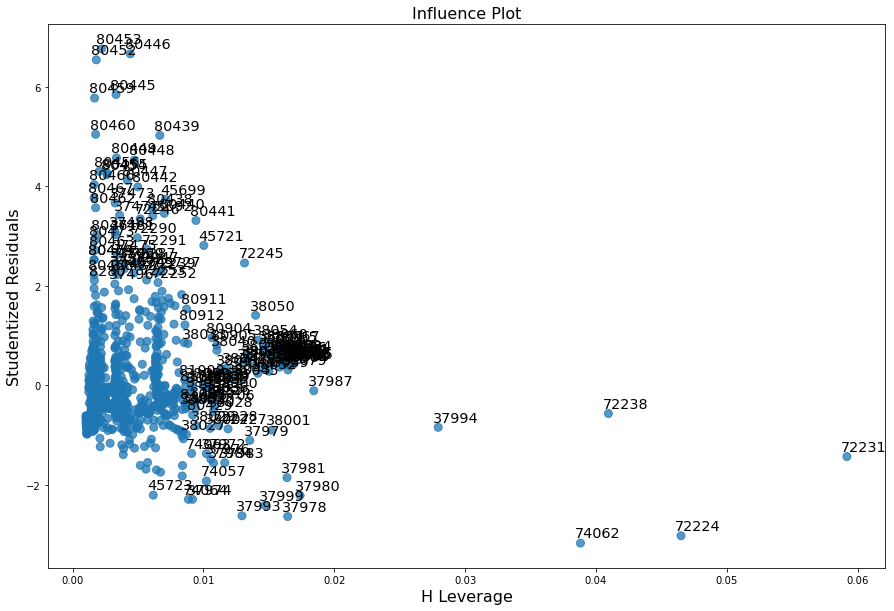

In [17]:
# leverage plot
fig, ax = plt.subplots(figsize=(15, 10))
_ = sm.graphics.influence_plot(final, size=8, ax=ax)

Some observations are high leverage and outliers, 74062 and 72224 have fairly high leverage and are more than 2 std from mean.

## Trying it with a polynomial for percentage vaccinated

Since the evaluation above suggested a polynomial might work better for percentage fully vaccinated, I decided to try a quick test.

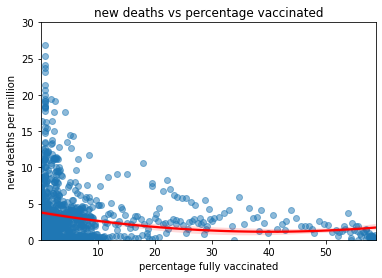

In [18]:
g = sns.regplot(data=dfx, x="percentage_fully_vaccinated", y="new_deaths_per_million", scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, order=2)
_ = g.set(ylim = (0, 30), xlabel='percentage fully vaccinated', ylabel='new deaths per million', title='new deaths vs percentage vaccinated')

In [19]:
# all together now
final = smf.ols('new_deaths_per_million ~ c_percentage_fully_vaccinated**2 + c_human_development_index + c_new_cases + c_extreme_poverty', data=dfx).fit()
final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     new_deaths_per_million   R-squared:                       0.352
Model:                                OLS   Adj. R-squared:                  0.350
Method:                     Least Squares   F-statistic:                     158.5
Date:                    Tue, 04 May 2021   Prob (F-statistic):          2.60e-108
Time:                            13:06:37   Log-Likelihood:                -2995.9
No. Observations:                    1170   AIC:                             6002.
Df Residuals:                        1165   BIC:                             6027.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.1337      0.092     34.151      0.000       2.954       3.314
c_percentage_fully_vaccinated    -0.0563      0.008     -7.257      0.000      -0.071      -0.041
c_human_development_index       -20.6747      7.906     -2.615      0.009     -36.185      -5.164
c_new_cases                       0.0089      0.000     19.782      0.000       0.008       0.010
c_extreme_poverty                 1.2755      0.330      3.866      0.000       0.628       1.923
==============================================================================
Omnibus:                      650.122   Durbin-Watson:                   0.707
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5921.138
Skew:                           2.430   Prob(JB):                         0.00
Kurtosis:                      12.891   Cond. No.                     1.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Judging by r squared, this has made no difference to the model.

## Summary

Three additional variables were added to my model of percentage of population vaccinated vs new deaths per million. These were Human Development Index (HDI), new cases per million and percentage of population in extreme poverty. None of the variables were found to be confounding, all were found to be significant, with extreme poverty (beta=1.2755, p<0.001) and new cases per million (beta=0.0089, p<0.001) found to be positively correlated with new deaths per million, and HDI (beta=-20.6747, p=0.009) and percentage fully vaccinated (beta=-0.0563, p<0.001) found to be negatively correlated with new deaths per million.

These results support my hypothesis that there is a negative association between the percentage of the population vaccinated against covid-19 and new deaths per million related to covid-19, as this relationship did not disappear no matter which of the other variables were added and remained significant throughout.

The finished model however was poor. The residuals did not show normal distribution, deviating especially in the highest quantile. While most of the observations fell within 2 standard deviations of the mean, some were as far as 6 standard deviations from the mean, suggesting a poor fit. More than 3% of the observations were further than 2.5 standard deviations from the mean, and 4.4% of them were more than 2 standard deviations from the mean. Again this suggests the model is a poor fit and needs improvement.

Examining the plots of residuals against each of my chosen variables suggested most errors were at the lower values, although this may be due to the fact that most observations were in the lower values. The partial regression plots showed many errors far from the lines suggesting a great number of prediction errors. The two plots for percentage fully vaccinated suggested a polynomial regression might help as there was an increase in errors again at higher values. Therefore, I tried the model again with a polynomial regression for percentage fully vaccinated, however there was no increase in accuracy of the model.

Looking at the leverage plot, I discovered I had some outliers that had high leverage, as observations 74062 and 72224 have fairly high leverage and are more than 2 std from the mean.

All in all it is clear that this is not a good model.